# 人脸表情识别

本期案例为通过深度学习网络识别人脸表情。这里我们使用的数据集为kaggle2013年表情识别数据集，表情一共分为7种，我们将构建深度学习网络，对表情进行分类，然后通过人脸识别检测人脸所在区域，分类判断出人脸表现出的表情。


### 进入ModelArts

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ， 进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

|项目|建议填写方式|
|-|-|
|名称|自定义环境名称|
|工作环境 | Python3|
| 资源池 | 选择"公共资源池"即可 |
|类型|GPU|
|规格|GPU:1*p100, CPU:8核64GiB|
|存储配置|EVS|
|磁盘规格|5GB|

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后选择TensorFlow 1.13.1开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"facial_expression"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！

### 数据和代码下载
运行下面代码，进行数据和代码的下载和解压


In [1]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_face_facial_expression/facial_expression.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_face_facial_expression/facial_expression.tar"
else:
    print("请更换地区到北京一或北京四")

sess.download_data(bucket_path=bucket_path, path="./facial_expression.tar")

Successfully download file modelarts-labs/notebook/DL_face_facial_expression/facial_expression.tar from OBS to local ./facial_expression.tar


# 解压文件

In [2]:
!tar -xf facial_expression.tar

In [3]:
!pip install mtcnn

You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 引用

In [4]:
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 参数设置

In [5]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [6]:
num_classes = 7 
batch_size = 16
epochs = 5

## 数据处理

In [7]:
with open("./fer2013/fer2013.csv") as f:
    content = f.readlines()
lines = np.array(content)

In [8]:
emotion_1, img_1, usage_1 = lines[1].split(",")

In [9]:
val_1 = img_1.split(" ")
pixels_1 = np.array(val_1, 'float32')
print(emotion_1)
print(usage_1)
print(pixels_1.shape)

0
Training

(2304,)


In [10]:
num_of_instances = lines.size
num_of_instances

35888

In [11]:
x_train, y_train, x_test, y_test = [], [], [], []

for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
        val = img.split(" ")
        pixels = np.array(val, 'float32')
        emotion = keras.utils.to_categorical(emotion, num_classes)
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

In [12]:
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28709 train samples
3589 test samples


In [13]:
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

## 模型构建

In [14]:
def build_model():
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [15]:
from keras.models import model_from_json
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.load_weights('./model/facial_expression_model_weights.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         147584    
__________

## 进行训练

In [17]:
model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) 

Instructions for updating:
Use tf.cast instead.


Epoch 1/5
16/16 [==============================] - 1s 91ms/step - loss: 0.7076 - acc: 0.7734
Epoch 2/5
16/16 [==============================] - 0s 6ms/step - loss: 0.6499 - acc: 0.7734
Epoch 3/5
16/16 [==============================] - 0s 6ms/step - loss: 0.7919 - acc: 0.7695
Epoch 4/5
16/16 [==============================] - 0s 6ms/step - loss: 0.6156 - acc: 0.7656
Epoch 5/5
16/16 [==============================] - 0s 6ms/step - loss: 0.5983 - acc: 0.7969


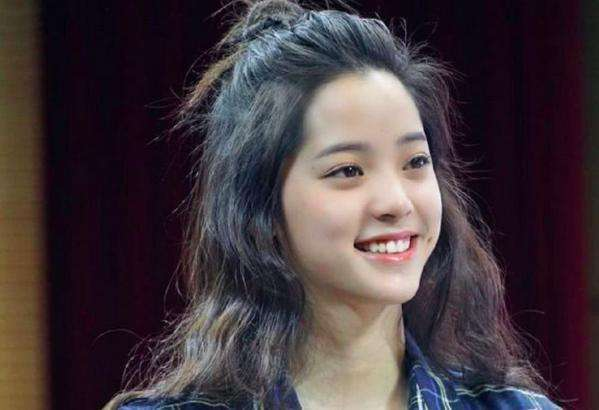

In [18]:
import cv2
img = cv2.cvtColor( cv2.imread("./img_nana_2.jpeg"), cv2.COLOR_BGR2RGB)

from PIL import Image
Image.fromarray(img)

In [19]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
result = detector.detect_faces(img)
result

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[{'box': [291, 80, 153, 224],
  'confidence': 0.9999819993972778,
  'keypoints': {'left_eye': (348, 173),
   'mouth_left': (357, 246),
   'mouth_right': (418, 237),
   'nose': (399, 205),
   'right_eye': (417, 163)}}]

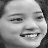

In [20]:
x,y,w,h = result[0]["box"]
detected_face = img[int(y):int(y+h), int(x):int(x+w)]
detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY)
detected_face = cv2.resize(detected_face, (48, 48)) 
Image.fromarray(detected_face)

In [21]:
from keras.preprocessing import image
import numpy as np
img_pixels = image.img_to_array(detected_face)
img_pixels = np.expand_dims(img_pixels, axis = 0)

img_pixels /= 255

predictions = model.predict(img_pixels) 
max_index = np.argmax(predictions[0])
result = emotions[max_index]
result

'happy'